# DNN: Comparative Study on CIFAR-10

## Briefer

|            |          |                      |
|------------|----------|----------------------|
| Subject    |          | Deep Neural Networks |
| Supervisor |          | Prof. Dinesh Babu J  |
|            |          |                      |
| Team Name  |          |                      |
| Member 1   | Name:    | Shreya Gupta         |
|            | Roll No: | MT2025724            |
| Member 2   | Name:    | Vibhuti Jain         |
|            | Roll No: | MT2025731            |
| Member 3   | Name:    | Anirudh Sharma       |
|            | Roll No: | MT2025732            |
|            |          |                      |

**Keywords:** NN, CNN, Activations, Optimisers, CIFAR-10

## Summary

* 4–8 bullet points summarizing highest-level conclusions (best model(s), tradeoffs, recommended next steps).
* Short comparative table of winners by criteria (accuracy, latency, model size, fairness, etc.)

## Introduction

* Problem statement and motivation
* Objectives of the comparative study (what questions you will answer)
* Scope (datasets, model families, compute constraints)
* Contributions (what unique analyses you provide - e.g., timing, memory profiling, calibration, fairness tests)

## System Imports

In [30]:
!pip install -q chime joblib pandas numpy scipy scikit-learn matplotlib seaborn tqdm ipython torch torchvision torchaudio torchmetrics

In [31]:
import chime
import os, random, time, json
import functools, itertools
import warnings, joblib, inspect

import pandas as pd, numpy as np, scipy as sp
import sklearn as skl
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as tutils
import torch.utils.benchmark as tben
import torch.nn.functional as F
import torch.profiler as profiler
import torchvision

from tqdm import tqdm
import IPython.display as d

## Project Space Setup

### Notification System Setup

In [32]:
chime.theme("material")
chime.info()

### Functional Setup

In [33]:
for working_directory in ["curated_submissions", "dumps", "report/figures",
                          "report/sections", "report/settings", "report/tables", "submissions"]:
    os.makedirs(working_directory, exist_ok=True)


# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)

### Graph Plotting System Setup

In [34]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
wid_fig = (8, 3)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(
        suptitle: str = None,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
        constrained=False):
    file_name = suptitle or title
    file_name = file_name.replace(':', '_').replace('/', '_')

    compose(plt.xlabel, x_label, font_label)
    compose(plt.ylabel, y_label, font_label)
    compose(plt.xticks, x_ticks, font_ticks)
    compose(plt.yticks, y_ticks, font_ticks)

    # if constrained:
    #     fig.set_constrained_layout(True)
    # else:
    #     plt.tight_layout()
    #
    # plt.savefig(f'report/figures/plot_{file_name}.png', dpi=300)

    compose(plt.suptitle, suptitle, font_suptitle)
    compose(plt.title, title, font_title)

    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()

    plt.show()


def conclude_csv(ds: pd.DataFrame, name=None, index=False, transpose=False):
    if name is None:
        if isinstance(ds, pd.Series):
            name = ds.name
        else:
            raise NameError()
    ds = ds.copy()
    if transpose: ds = ds.transpose()
    ds = ds.round(2)
    ds.to_csv(f'report/tables/data_{name}.csv', index=index, encoding="utf-8")


chime.info()

### Randomizer System Setup

In [35]:
default_seed = 1114
current_seed = default_seed


def reset_seed(seed=default_seed):
    global current_seed
    current_seed = seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if hasattr(torch, "cuda"):
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


reset_seed()
chime.info()

### Presentation System Setup

In [36]:
markdown = lambda *x: display(d.Markdown(" ".join(x)))

subsection = lambda x: markdown(f"### {x}")
statement = lambda x: markdown(f"#### {x}")
quote = lambda field: markdown("\n\n> %s" % field.strip().replace("\n", "<br>"))
list_out = lambda t, l: statement("%s\n\n* %s" % (t, "\n* ".join(map(str, l))))
tab_out = lambda t: markdown(f"""
| {" | ".join(t.columns)} |
| {" | ".join("-" * len(t.columns))} |
{"\n".join([f"| {" | ".join(map(str, r))} |" for r in t.iloc])}
""")

kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())

### Transformation System Setup

### Modelling System Setup

### Other Setups

## Data Loading and Description

In [37]:
%time

ds_train = torchvision.datasets.cifar.CIFAR10(root='../../data', download=True)
ds_test = torchvision.datasets.cifar.CIFAR10(train=False, root='../../data', download=True)

display(", ".join([x for x in dir(ds_train) if not x.startswith('_')]))

CPU times: total: 0 ns
Wall time: 0 ns


'base_folder, class_to_idx, classes, data, download, extra_repr, filename, meta, root, target_transform, targets, test_list, tgz_md5, train, train_list, transform, transforms, url'

In [38]:
ds_class_to_idx = pd.DataFrame(data=[*ds_train.class_to_idx.items()], columns=["Class Name", "Class ID"])
tab_out(ds_class_to_idx)


| Class Name | Class ID |
| - | - |
| airplane | 0 |
| automobile | 1 |
| bird | 2 |
| cat | 3 |
| deer | 4 |
| dog | 5 |
| frog | 6 |
| horse | 7 |
| ship | 8 |
| truck | 9 |


In [39]:
# Analyze basic data shape - input features and target column

data_shape = ds_train.data.shape
n_samples = data_shape[0]
n_features = np.prod(data_shape[1:])
n_targets = len(ds_train.classes)

statement(kv('Number of total samples', n_samples))
statement(kv('Number of features', n_features))
statement(kv('Number of classes in target feature', n_targets))

#### **Number of total samples:** `50000`

#### **Number of features:** `3072`

#### **Number of classes in target feature:** `10`

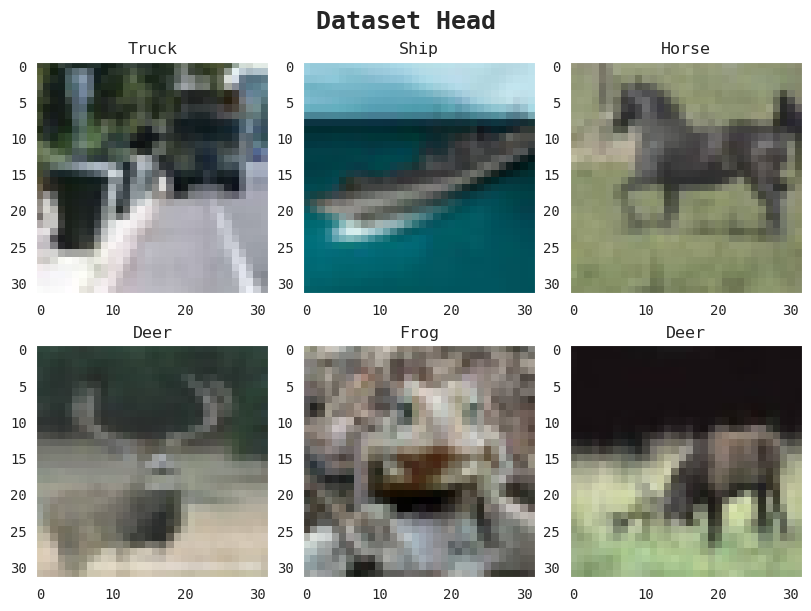

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(wid_fig[0], 6))
idxs = np.random.choice(n_samples, size=6, replace=False)
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(ds_train.data[idx])
    ax.set_title(ds_train.classes[ds_train.targets[idx]].title())
    ax.grid(False)

conclude_plot("Dataset Head", constrained=True)

### Data Meta

In [41]:
statement(kv("Data Type", ds_train.data.dtype))
statement(kv("Max Value", np.max(ds_train.data)))
statement(kv("Min Value", np.min(ds_train.data)))

#### **Data Type:** `uint8`

#### **Max Value:** `255`

#### **Min Value:** `0`

### Feature Meta

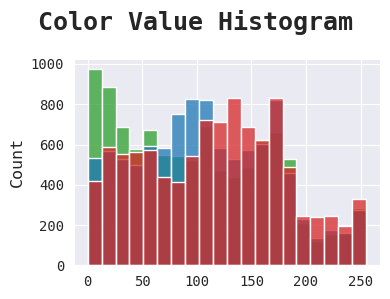

In [42]:
plt.figure(figsize=sml_fig)
sns.histplot(ds_train.data[::5000, :, :, 2].flatten(), label="Blue", color="#2ca02c", bins=20)
sns.histplot(ds_train.data[::5000, :, :, 1].flatten(), label="Green", color="#1f77b4", bins=20)
sns.histplot(ds_train.data[::5000, :, :, 0].flatten(), label="Red", color="#d62728", bins=20)
conclude_plot("Color Value Histogram")

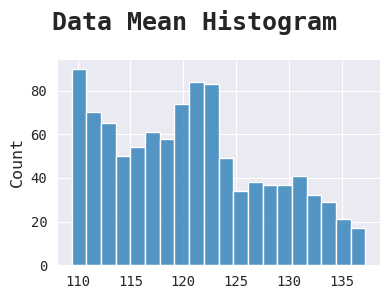

In [43]:
plt.figure(figsize=sml_fig)
ds_features_mean = np.mean(ds_train.data, axis=(0, 3)).flatten()
sns.histplot(ds_features_mean, bins=20)
conclude_plot("Data Mean Histogram")

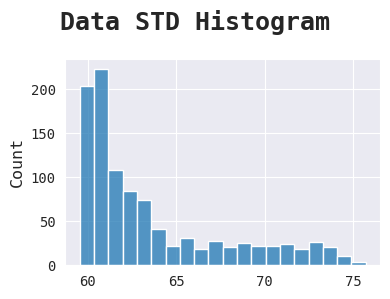

In [44]:
plt.figure(figsize=sml_fig)
ds_std = np.std(ds_train.data, axis=(0, 3)).flatten()
sns.histplot(ds_std, bins=20)
conclude_plot("Data STD Histogram")

### Missing Values

In [45]:
missing_count = np.sum(np.isnan(ds_train.data))
statement(kv("Number of samples with invalid state", missing_count))

#### **Number of samples with invalid state:** `0`

### Duplicate Counts

In [46]:
_ds_flat = ds_train.data.reshape(n_samples, -1)
_ds_bytes = np.ascontiguousarray(_ds_flat).view(np.dtype((np.void, _ds_flat.dtype.itemsize * _ds_flat.shape[1])))

duplicate_count = np.unique(_ds_bytes, return_counts=True)[1]
duplicate_count = np.sum(duplicate_count > 1)

statement(kv("Number of duplicated samples", duplicate_count))

#### **Number of duplicated samples:** `0`

### Outlier Detection

In [47]:
statement(kv("Invalid PIxels", np.sum(np.isnan(ds_train.data).any(axis=(0, 1, 2, 3)))))
statement(kv("Blank Images", np.sum(np.all(ds_train.data == 0, axis=(1, 2, 3)))))
ds_images_mean = np.mean(ds_train.data, axis=(1, 2, 3))
statement(kv("Over Exposed", np.sum(ds_images_mean > 256 * 0.9)))
statement(kv("Under Exposed", np.sum(ds_images_mean < 256 * 0.1)))

#### **Invalid PIxels:** `0`

#### **Blank Images:** `0`

#### **Over Exposed:** `43`

#### **Under Exposed:** `32`

## Data Modelling

### Re-Shaping for PyTorch

In [60]:
ds_train.data = np.transpose(ds_train.data, (0, 3, 1, 2))
ds_test.data = np.transpose(ds_test.data, (0, 3, 1, 2))

statement(kv("Data Shape", ds_train.data.shape))

#### **Data Shape:** `(50000, 3, 32, 32)`

### Data Scaling
Since we are applying a fixed scale of [0, 1], we do not need to scale train (fit) and test (tr) separately.

In [61]:
ds_train.data = (ds_train.data / 255).astype(np.float16)
ds_test.data = (ds_test.data / 255).astype(np.float16)

statement(kv("Data Shape", ds_train.data.shape))

#### **Data Shape:** `(50000, 3, 32, 32)`

### Train-Validation Split

In [62]:
reset_seed()

train_x, val_x, train_y, val_y = skl.model_selection.train_test_split \
    (ds_train.data, ds_train.targets, test_size=5000,
     random_state=current_seed, stratify=ds_train.targets)

statement(kv("Train Set Size", len(train_x)))
statement(kv("Val Set Size", len(val_x)))
statement(kv("Test Set Size", len(ds_test.data)))

#### **Train Set Size:** `45000`

#### **Val Set Size:** `5000`

#### **Test Set Size:** `50000`

In [70]:
def data_step(device):
    device = torch.device(device)

    tensor_train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    tensor_train_y = torch.tensor(train_y, dtype=torch.long, device=device)
    tensor_val_x = torch.tensor(val_x, dtype=torch.float32, device=device)
    tensor_val_y = torch.tensor(val_y, dtype=torch.long, device=device)
    tensor_test_x = torch.tensor(ds_test.data, dtype=torch.float32, device=device)
    tensor_test_y = torch.tensor(ds_test.targets, dtype=torch.long, device=device)

    dataset_train = tutils.data.TensorDataset(tensor_train_x, tensor_train_y)
    dataset_val = tutils.data.TensorDataset(tensor_val_x, tensor_val_y)
    print(tensor_test_x.shape, tensor_test_y.shape)
    dataset_test = tutils.data.TensorDataset(tensor_test_x, tensor_test_y)

    return dataset_train, dataset_val, dataset_test

In [64]:
def batch_step(batch_size, *datasets):
    dataset_train, dataset_val, dataset_test = datasets
    reset_seed()

    if batch_size is None:
        batch_size = len(dataset_train)

    loader_train = tutils.data.DataLoader \
        (dataset_train, batch_size=batch_size,
         shuffle=True, pin_memory=True, num_workers=4)
    loader_val = tutils.data.DataLoader \
        (dataset_val, batch_size=len(dataset_val),
         shuffle=False, pin_memory=True)
    loader_test = tutils.data.DataLoader \
        (dataset_test, batch_size=len(dataset_test),
         shuffle=False, pin_memory=True)

    return loader_train, loader_val, loader_test

In [65]:
def model_step(n_convs, n_fcs, i_act, n_cls, device):
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            layers = []

            layers.append(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1, device=device))
            layers.append(i_act())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            for i in range(n_convs - 1):
                layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1, device=device))
                layers.append(i_act())
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            layers.append(nn.Flatten())
            _flat_in = 30 // (2 ** n_convs)
            layers.append(nn.Linear(_flat_in, 1024, device=device))
            layers.append(i_act())

            for i in range(n_fcs - 2):
                layers.append(nn.Linear(1024, 1024, device=device))
                layers.append(i_act())

            layers.append(nn.Linear(1024, n_cls, device=device))
            layers.append(i_act())

            for index, layer in enumerate(layers):
                setattr(self, 'layer{}'.format(index), layer)
            self.layers = layers

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            # Generally, there is no need to apply softmax here, since Cross Entropy automatically considers and optimizes on the logits
            # return F.softmax(layers[-1](x), dim=1)
            return x

    return Model()

In [66]:
def set_learning_rate(optimizer, learning_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate


def optimizer_step(optim_strategy, learning_rate, model):
    if optim_strategy is None:
        return optim.SGD(params=model.parameters(), lr=learning_rate)
    if optim_strategy == 'Momentum':
        return optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
    if optim_strategy == 'AdaptiveLR':
        return optim.RMSprop(params=model.parameters(), lr=learning_rate, alpha=0.99)
    if optim_strategy == 'Both':
        return optim.Adam(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
    return None

In [67]:
def train_step(
        model, loaders, criterion, optimizer,
        learning_rate, label, limit):
    start_time = tben.timer()

    model.train()
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    loader_train, loader_val, _ = loaders

    skip_batches = 1
    no_of_batches = len(loader_train)
    if no_of_batches > 100:
        skip_batches = no_of_batches // 100

    set_learning_rate(optimizer, learning_rate)

    with (tqdm(total=no_of_batches) as pbar):
        for batch, (x_batch, y_batch) in enumerate(loader_train):
            if limit is not None and batch >= limit:
                break

            p_batch = model(x_batch)  # Predictions
            loss = criterion(p_batch, y_batch)
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            c_batch = torch.argmax(torch.softmax(p_batch, dim=1), dim=1)  # Classes
            train_acc.append((c_batch == y_batch).sum().item() / len(y_batch))

            pbar.desc = f"%s [Train] Loss: %9.6f Accuracy: %7.6f" % \
                        (label, train_loss[-1], train_acc[-1])
            pbar.update(1)

            if batch == 0 or (batch - 1) % skip_batches == 0:
                model.eval()

                with torch.no_grad():
                    x_batch, y_batch = next(iter(loader_val))
                    p_batch = model(x_batch)
                    loss = criterion(p_batch, y_batch)
                    val_loss.append(loss.item())

                    c_batch = torch.argmax(torch.softmax(p_batch, dim=1), dim=1)  # Classes
                    val_acc.append((c_batch == y_batch).sum().item() / len(y_batch))

                model.train()

    return {'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss,
            'val_acc': val_acc, 'total_time': tben.timer() - start_time}

In [1]:
def run_experiment(
        conv_count, fc_count, activation,
        batch_size,
        optim_strategy,
        learning_rate,
        device,
        epochs=1, limit=None,
):
    criterion = nn.CrossEntropyLoss()
    datasets = data_step(device)
    loaders = batch_step(batch_size, *datasets)
    model = model_step(conv_count, fc_count, activation, 10, device)
    optimizer = optimizer_step(optim_strategy, learning_rate, model)
    histories = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'total_time': 0,
                 'parameters': {'conv_count': str(conv_count), 'fc_count': str(fc_count), 'activation': str(activation),
                                'batch_size': str(batch_size), 'optim_strategy': str(optim_strategy),
                                'learning_rate': str(learning_rate), 'epochs': str(epochs)},
                 'model': model,

                 }
    for epoch in range(epochs):
        label = f"Epoch {epoch + 1}/{epochs}"
        history = train_step(model, loaders, criterion, optimizer,
                             learning_rate, label, limit)
        for aspect in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
            histories[aspect].extend(history[aspect])
        histories['total_time'] += history['total_time']
    return histories

In [71]:
h = run_experiment(
    conv_count=2, fc_count=3, activation=nn.ReLU,
    batch_size=1024,
    optim_strategy=None,
    learning_rate=0.01,
    device='cpu',
    epochs=1, limit=1,
)

torch.Size([50000, 3, 32, 32]) torch.Size([10000])


AssertionError: Size mismatch between tensors

In [58]:
nn.Conv2d(3, 32, kernel_size=3)(torch.randn(1, 3, 32, 32))

tensor([[[[-0.0180,  0.1428, -0.8184,  ..., -0.7898, -1.4703, -0.6929],
          [-1.3464,  0.2659,  0.5515,  ...,  0.7948, -0.1779,  0.1770],
          [-0.2710, -0.1167, -0.3912,  ...,  0.0414, -0.0031,  0.1179],
          ...,
          [-1.2517, -0.3118,  0.7501,  ..., -0.2168, -0.4095, -0.6415],
          [ 0.0483, -0.0598,  0.9265,  ...,  0.3788,  0.1599, -0.5488],
          [ 1.3707,  0.0598, -0.5085,  ..., -0.4993,  0.3918, -1.2168]],

         [[ 0.3563,  0.4182,  0.1842,  ...,  0.3169,  0.0100,  0.4796],
          [ 0.1512,  0.2613,  0.3493,  ...,  0.0118,  1.0577,  0.3399],
          [ 1.5595, -0.2566, -0.3057,  ..., -0.4188,  0.5400, -0.8063],
          ...,
          [-0.3910,  0.7853,  0.4219,  ..., -0.3866, -0.3155,  0.1191],
          [ 0.7268,  0.7935,  0.2490,  ...,  0.0157,  0.1187,  0.2066],
          [-0.2947,  0.2665, -0.8548,  ...,  0.4922, -0.4929, -0.5638]],

         [[-0.1907,  0.3698,  0.7508,  ..., -0.3767, -0.4007,  0.2676],
          [-0.0160,  0.0246,  

In [56]:
ds_train.classes
ds_train.data
ds_train.targets
ds_train.url

'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

In [57]:
ds_train.data.shape

(50000, 32, 32, 3)

In [63]:
len(ds_test.targets)

10000